In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from scipy import stats

import plotly.io as pio
pio.renderers.default = "png"

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import train_test_split

from statsmodels import api as sm

from functions import df_engineered

In [47]:
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
print('df shape:', df.shape)

data = df_engineered(df)

df shape: (2580, 80)


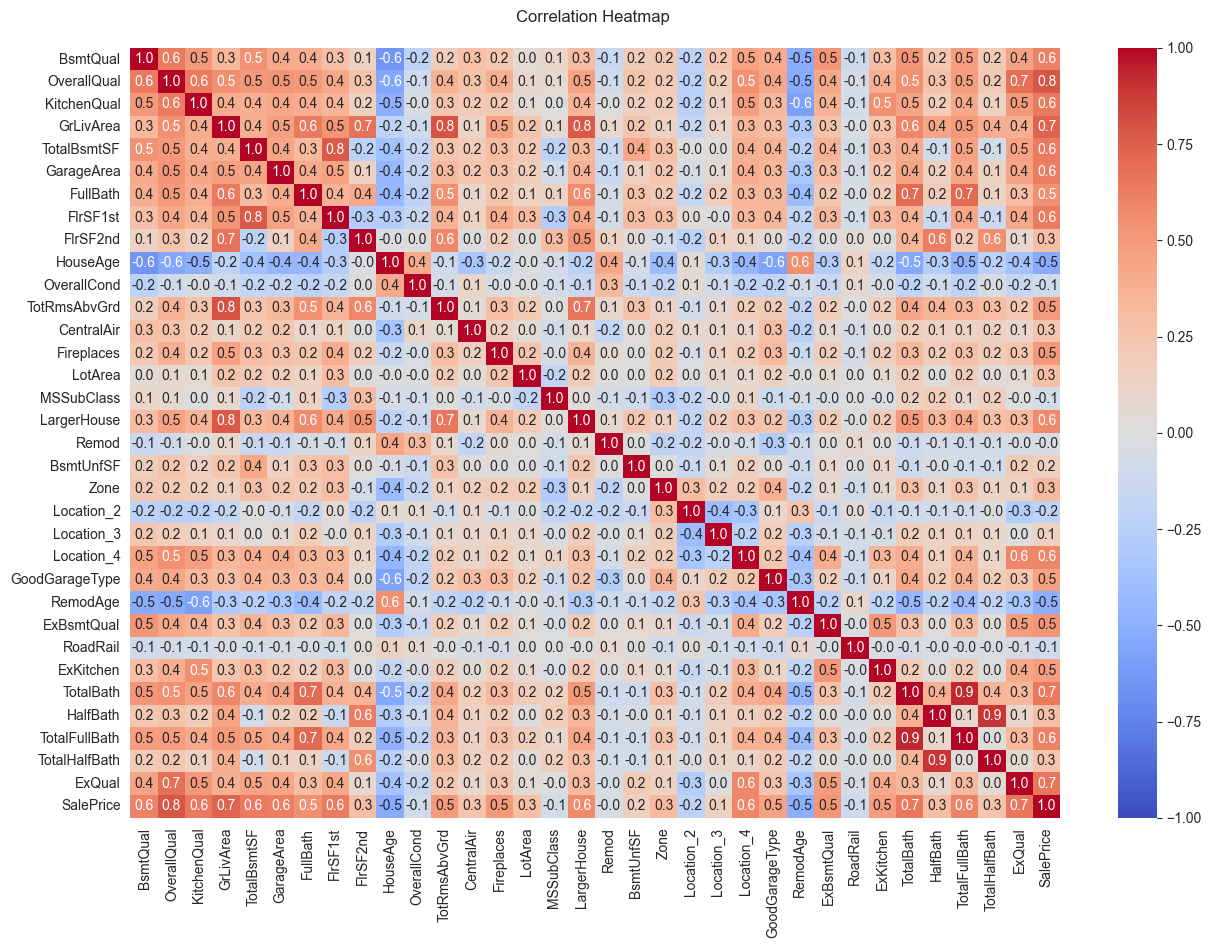

In [48]:
feature_selection = ['BsmtQual' , 'OverallQual' , 'KitchenQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea' , 'FullBath' , 'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'TotRmsAbvGrd' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'MSSubClass' , 'LargerHouse' , 'Remod',
                    'BsmtUnfSF' , 'Zone' , 'Location_2', 'Location_3' , 'Location_4' , 'GoodGarageType',
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail', 'ExKitchen' , 'TotalBath', 
                    'HalfBath', 'TotalFullBath', 'TotalHalfBath', 'ExQual']

plt.figure(figsize=(15, 10))

corr_mat = data[feature_selection + ['SalePrice']].corr()

sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            cmap='coolwarm'
            )
title = plt.title('Correlation Heatmap \n')

In [49]:
skewness = data[feature_selection].skew().sort_values(ascending=False)
print(skewness[abs(skewness) > 0.75])
skewed_cols = list(skewness[abs(skewness) > 0.75].index)

data['LotArea'] = np.log(data['LotArea'])

LotArea       13.647537
ExKitchen      4.212534
RoadRail       3.690437
ExBsmtQual     3.571738
ExQual         2.079905
Location_4     1.821239
Location_3     1.405190
MSSubClass     1.339800
FlrSF1st       1.045575
BsmtUnfSF      0.981279
GrLivArea      0.943880
FlrSF2nd       0.804334
Zone          -1.733407
CentralAir    -3.705920
dtype: float64


In [50]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data[['SalePrice']], test_size=0.30, random_state=42)

# Model

### Standardization

In [51]:
scaler = StandardScaler()

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = np.log(y_train.reset_index(drop=True)['SalePrice'])
y_test = np.log(y_test.reset_index(drop=True)['SalePrice'])

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[feature_selection]), columns=X_train[feature_selection].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[feature_selection]), columns=X_test[feature_selection].columns)

## Linear Regression

In [52]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ols, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9274 0.9267 0.9327 0.9321 0.9487]
Mean shuffled cross validation score: 0.9335
RMSE Shuffled cross validation score: [0.0948 0.1002 0.0909 0.0976 0.083 ]
RMSE Mean shuffled cross validation score: 0.0933


In [53]:
test_score = ols.score(X_test_scaled, y_test)

print('Test score:', np.round(test_score, 4))

rms = mean_squared_error(y_test, ols.predict(X_test_scaled), squared=False)
print('RMSE Test score:', np.round(rms, 4))

Test score: 0.9317
RMSE Test score: 0.0977


In [54]:
yhat_train = ols.predict(X_train_scaled)
yhat_test = ols.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16548.779172332528
16946.563195221155


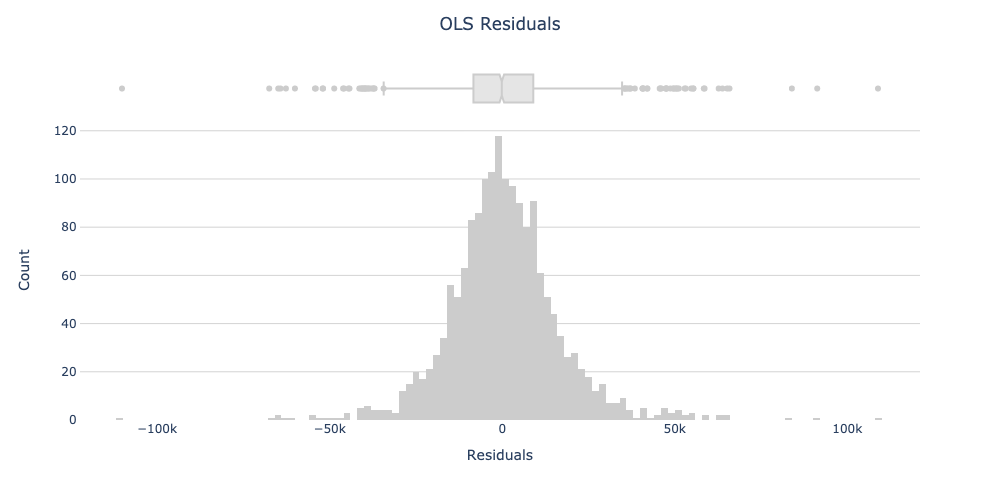

In [55]:
yhat = ols.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                pd.concat([X_train, np.exp(y_train)], axis=1), 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])

#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='OLS Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

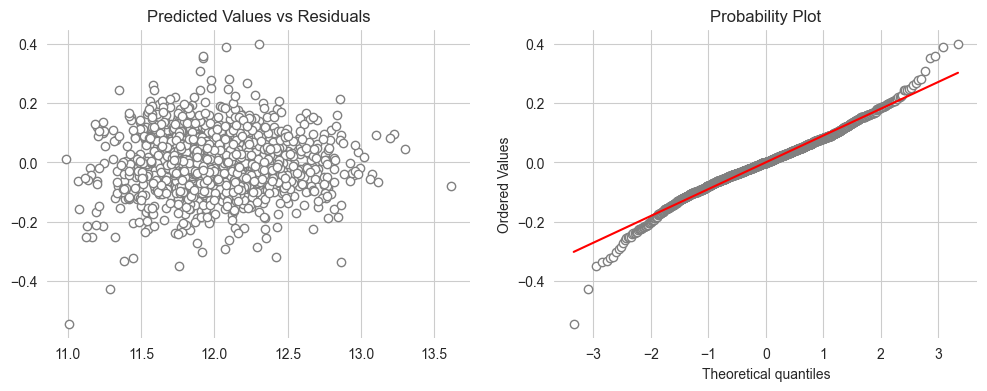

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [57]:
res = stats.shapiro(residuals)
res.statistic

0.9812881946563721

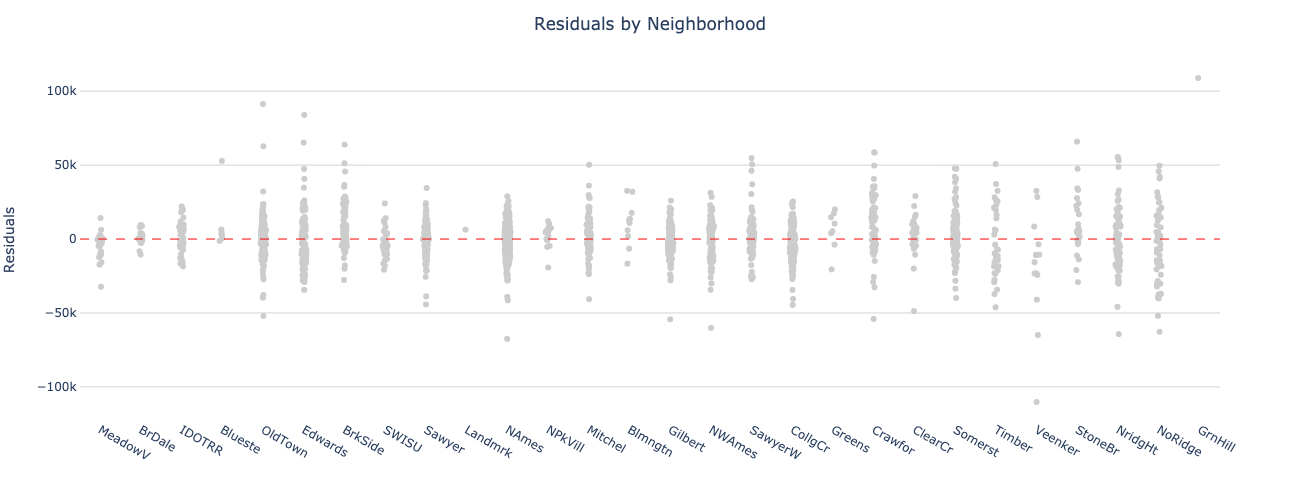

In [58]:
order = results.groupby('Neighborhood').SalePrice.median().sort_values().index

fig = px.strip(
            results, 
            x='Neighborhood', 
            y='residual',
            category_orders={'Neighborhood':order},
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by Neighborhood', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

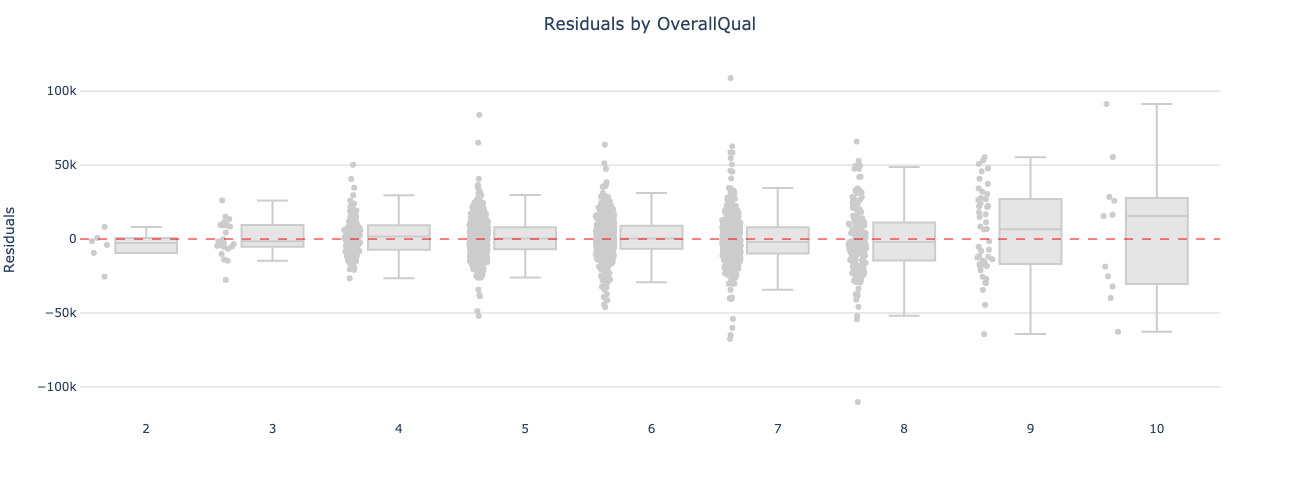

In [59]:
order = results.groupby('OverallQual').SalePrice.median().sort_values().index

fig = px.box(
            results, 
            x='OverallQual', 
            y='residual',
            category_orders={'OverallQual':order},
            points="all",
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by OverallQual', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

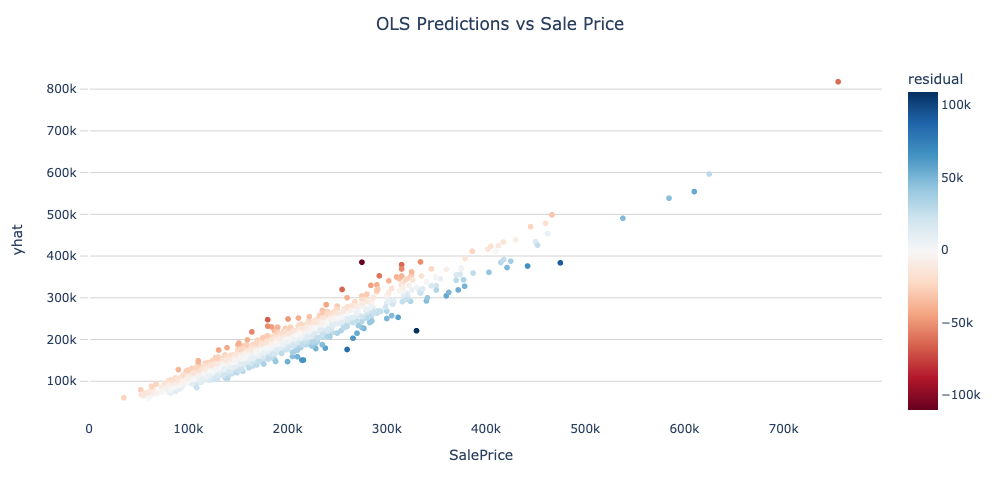

In [60]:
fig = px.scatter(
            results, 
            x='SalePrice', 
            y='yhat',
            color='residual',
            color_continuous_scale='RdBu',
            width=1000)

fig.update_layout(
            title='OLS Predictions vs Sale Price', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')
            
fig.update_yaxes(
            showline=True,
            gridcolor='lightgray')
            
fig.show()

## Lasso

In [61]:
lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

best_alpha = lasso.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_lasso)


Best alpha: 0.0008444002079826451
RMSE: 0.09807730670423377


In [62]:
kf = KFold(n_splits=2, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(lasso, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9296 0.9375]
Mean shuffled cross validation score: 0.9335
RMSE Shuffled cross validation score: [0.0961 0.0911]
RMSE Mean shuffled cross validation score: 0.0936


In [63]:
yhat_train = lasso.predict(X_train_scaled)
yhat_test = lasso.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16500.753612272023
17046.47726316449


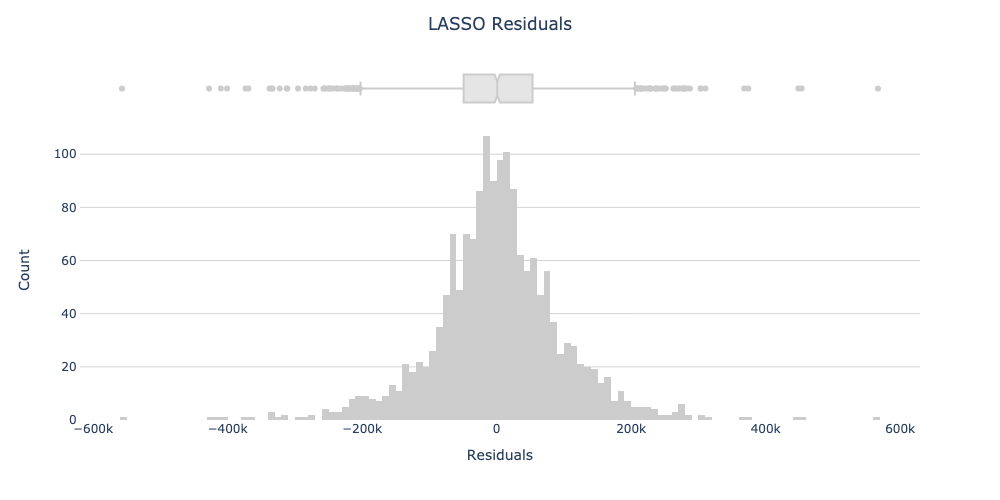

In [64]:
yhat = lasso.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='LASSO Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

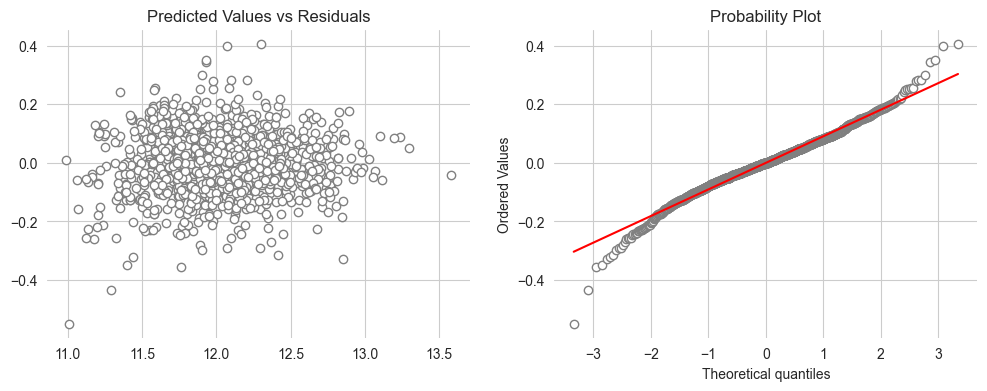

In [65]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [66]:
res = stats.shapiro(residuals)
res.statistic

0.9806256890296936

## Ridge

In [67]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train_scaled, y_train)

best_alpha = ridge.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_ridge)


Best alpha: 10.0
RMSE: 0.09774980672120266


In [68]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ridge, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9273 0.9268 0.9331 0.9325 0.9486]
Mean shuffled cross validation score: 0.9336
RMSE Shuffled cross validation score: [0.0949 0.1001 0.0907 0.0973 0.0831]
RMSE Mean shuffled cross validation score: 0.0932


In [69]:
yhat_train = ridge.predict(X_train_scaled)
yhat_test = ridge.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16516.89884207406
16959.881821774932


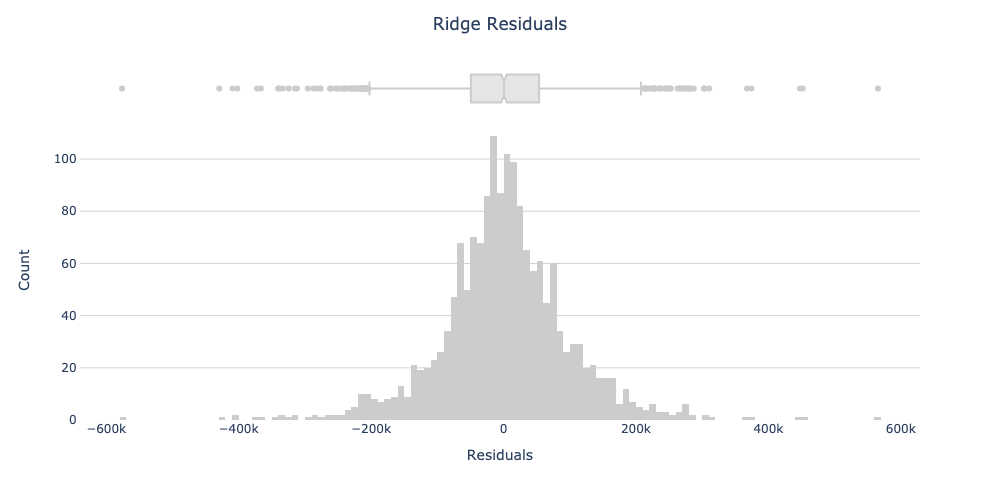

In [70]:
yhat = ridge.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='Ridge Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

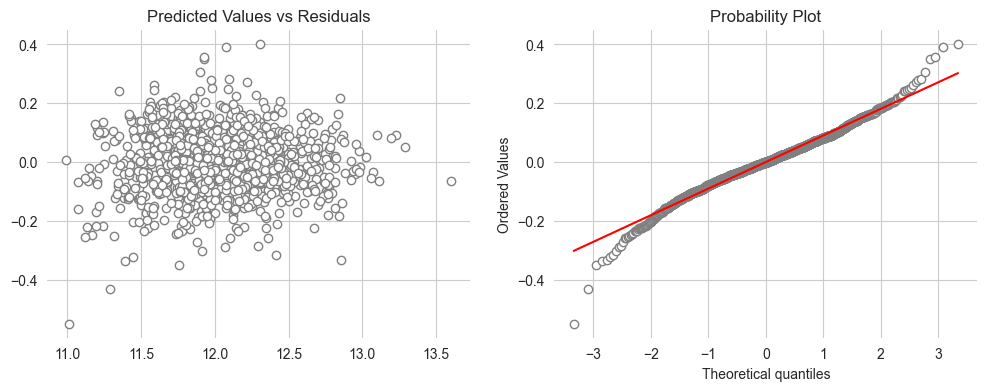

In [71]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [72]:
res = stats.shapiro(residuals)
res.statistic

0.9810500144958496

## Stats model

In [157]:
X_train_scaled_sm = sm.add_constant(X_train_scaled)

model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                    GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                    HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                    Fireplaces + LotArea + MSSubClass + Remod +\
                    BsmtUnfSF + Zone + Location_2 + Location_3 + Location_4 +\
                    RemodAge + ExBsmtQual + RoadRail + ExKitchen + TotalBath + \
                    GrLivArea:Fireplaces', 
                    data=pd.concat([X_train_scaled_sm, y_train], axis=1))

results_fu = model.fit()

n = X_train.shape[0]
results_fr = model.fit_regularized(L1_wt=0, alpha=0.9/n, start_params=results_fu.params)

#test_params = np.insert(ridge.coef_, 0, ridge.intercept_, axis=0)
test_params = np.round(results_fr.params, 6)
test_params[0] = results_fu.params[0]

final = sm.regression.linear_model.OLSResults(model, 
                                              test_params,
                                              model.normalized_cov_params)

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     895.5
Date:                Fri, 04 Aug 2023   Prob (F-statistic):               0.00
Time:                        10:53:05   Log-Likelihood:                 1626.1
No. Observations:                1678   AIC:                            -3196.
Df Residuals:                    1650   BIC:                            -3044.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.0177      0.002   4811.660      0.000      12.013      12.023
BsmtQual                 0.0091      0.004      2.100      0.036       0.001       0.018
OverallQual              0.0884      0.004     21.894      0.000       0.081       0.096
GrLivArea                0.0839      0.025      3.407      0.001       0.036       0.132
TotalBsmtSF              0.0695      0.005     13.794      0.000       0.060       0.079
GarageArea               0.0275      0.003      9.211      0.000       0.022       0.033
FullBath                -0.0109      0.004     -2.676      0.008      -0.019      -0.003
FlrSF1st                 0.0290      0.019      1.526      0.127      -0.008       0.066
FlrSF2nd                 0.0375      0.022      1.717      0.086      -0.005       0.080
HouseAge                -0.0516      0.005    -10.064      0.000      -0.062      -0.042
OverallCond              0.0520      0.003     17.293      0.000       0.046       0.058
TotRmsAbvGrd            -0.0061      0.004     -1.453      0.146      -0.014       0.002
CentralAir               0.0193      0.003      7.414      0.000       0.014       0.024
Fireplaces               0.0235      0.003      8.553      0.000       0.018       0.029
LotArea                  0.0442      0.003     13.066      0.000       0.038       0.051
MSSubClass              -0.0025      0.003     -0.808      0.419      -0.009       0.004
Remod                   -0.0037      0.003     -1.253      0.210      -0.009       0.002
BsmtUnfSF               -0.0321      0.003     -9.450      0.000      -0.039      -0.025
Zone                     0.0120      0.003      3.588      0.000       0.005       0.019
Location_2               0.0053      0.004      1.294      0.196      -0.003       0.013
Location_3               0.0308      0.004      7.490      0.000       0.023       0.039
Location_4               0.0431      0.004      9.594      0.000       0.034       0.052
RemodAge                -0.0206      0.004     -5.756      0.000      -0.028      -0.014
ExBsmtQual               0.0098      0.003      3.077      0.002       0.004       0.016
RoadRail                -0.0112      0.002     -4.851      0.000      -0.016      -0.007
ExKitchen                0.0099      0.003      3.653      0.000       0.005       0.015
TotalBath                0.0137      0.005      2.955      0.003       0.005       0.023
GrLivArea:Fireplaces    -0.0052      0.002     -2.138      0.033      -0.010      -0.000
==============================================================================
Omnibus:                       87.338   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.688
Skew:                          -0.171   Prob(JB):                     8.28e-61
Kurtosis

In [158]:
yhat_train = final.predict(X_train_scaled)
yhat_test = final.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16586.857642956984
16883.39163805164


In [159]:
yhat_train = final.predict(X_train_scaled)
yhat_test = final.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

0.09181179596351259
0.09775020810276784


## Interactions with Location

In [333]:
data = df_engineered(df, Reg=False)

In [334]:
#temp = data[data.Location==4]
temp = data[data.LargerHouse==0]

X_train_loc, X_test_loc, y_train_loc, y_test_loc = \
    train_test_split(temp.drop(columns='SalePrice'), temp[['SalePrice']], test_size=0.30, random_state=42)

### Standardization

In [335]:
feature_selection = ['BsmtQual' , 'OverallQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea', 'FullBath' ,'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'TotRmsAbvGrd' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'MSSubClass' , 'Remod',
                    'BsmtUnfSF' , 'Zone' , 'Location',
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail', 'KitchenQual' , 'HalfBath']

In [336]:
scaler = StandardScaler()

X_train_loc = X_train_loc.reset_index(drop=True)
X_test_loc = X_test_loc.reset_index(drop=True)

y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)

In [337]:
X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                    GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                    HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                    Fireplaces + LotArea + MSSubClass + Remod +\
                    BsmtUnfSF + Zone + Location +\
                    RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + \
                    GrLivArea:Fireplaces', 
                    data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

results_fu = model.fit()

n = X_train.shape[0]
results_fr = model.fit_regularized(L1_wt=0, alpha=0.1/n, start_params=results_fu.params)

#test_params = np.insert(ridge.coef_, 0, ridge.intercept_, axis=0)
test_params = np.round(results_fr.params, 6)
test_params[0] = results_fu.params[0]

final = sm.regression.linear_model.OLSResults(model, 
                                              test_params,
                                              model.normalized_cov_params)

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     270.8
Date:                Fri, 04 Aug 2023   Prob (F-statistic):               0.00
Time:                        11:24:31   Log-Likelihood:                 890.14
No. Observations:                 913   AIC:                            -1728.
Df Residuals:                     887   BIC:                            -1603.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               11.8042      0.003   3541.947      0.000      11.798      11.811
BsmtQual                 0.0095      0.005      1.805      0.071      -0.001       0.020
OverallQual              0.0619      0.005     13.388      0.000       0.053       0.071
GrLivArea                0.0406      0.027      1.524      0.128      -0.012       0.093
TotalBsmtSF              0.0453      0.006      7.519      0.000       0.033       0.057
GarageArea               0.0333      0.004      9.183      0.000       0.026       0.040
FullBath                -0.0113      0.004     -2.591      0.010      -0.020      -0.003
FlrSF1st                 0.0543      0.031      1.740      0.082      -0.007       0.116
FlrSF2nd                 0.0445      0.030      1.459      0.145      -0.015       0.104
HouseAge                -0.0564      0.007     -8.505      0.000      -0.069      -0.043
OverallCond              0.0493      0.004     12.291      0.000       0.041       0.057
TotRmsAbvGrd             0.0011      0.004      0.262      0.793      -0.007       0.010
CentralAir               0.0157      0.004      4.145      0.000       0.008       0.023
Fireplaces               0.0178      0.004      4.725      0.000       0.010       0.025
LotArea                  0.0266      0.004      6.886      0.000       0.019       0.034
MSSubClass              -0.0092      0.004     -2.150      0.032      -0.018      -0.001
Remod                   -0.0028      0.004     -0.620      0.535      -0.011       0.006
BsmtUnfSF               -0.0273      0.004     -7.189      0.000      -0.035      -0.020
Zone                     0.0134      0.004      3.161      0.002       0.005       0.022
Location                 0.0346      0.005      7.194      0.000       0.025       0.044
RemodAge                -0.0134      0.005     -2.842      0.005      -0.023      -0.004
ExBsmtQual               0.0055      0.003      1.687      0.092      -0.001       0.012
RoadRail                -0.0137      0.003     -4.343      0.000      -0.020      -0.008
KitchenQual              0.0085      0.004      2.202      0.028       0.001       0.016
HalfBath                -0.0110      0.004     -2.713      0.007      -0.019      -0.003
GrLivArea:Fireplaces    -0.0120      0.004     -3.250      0.001      -0.019      -0.005
==============================================================================
Omnibus:                      210.477   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1270.557
Skew:                          -0.905   Prob(JB):                    1.27e-276
Kurtosis:                       8.489   Cond. No.                         38.9
==============================================================================

Notes:
[1] Standard Errors 

In [338]:
yhat_train_loc = final.predict(X_train_scaled_loc)
yhat_test_loc = final.predict(X_test_scaled_loc)

train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

12029.213454270859
12841.20180309485


In [339]:
import math

unscaled_coef = final.params[1:]

transformed_coef = []
for i in unscaled_coef:
    j = math.exp(i)
    transformed_coef.append(j)

In [340]:
coef_effect = [(i - 1)*df.SalePrice.mean() for i in transformed_coef]

var_impact = pd.DataFrame(data=[X_train_scaled_loc.columns, coef_effect]).T
var_impact.columns = ["variable", "1-unit change"]
var_impact

,variable,1-unit change
0,BsmtQual,1694.953186
1,OverallQual,11379.070488
2,GrLivArea,7379.834653
3,TotalBsmtSF,8257.177795
4,GarageArea,6020.378693
5,FullBath,-1992.297197
6,FlrSF1st,9938.965525
7,FlrSF2nd,8096.083446
8,HouseAge,-9758.217083
9,OverallCond,8992.526994


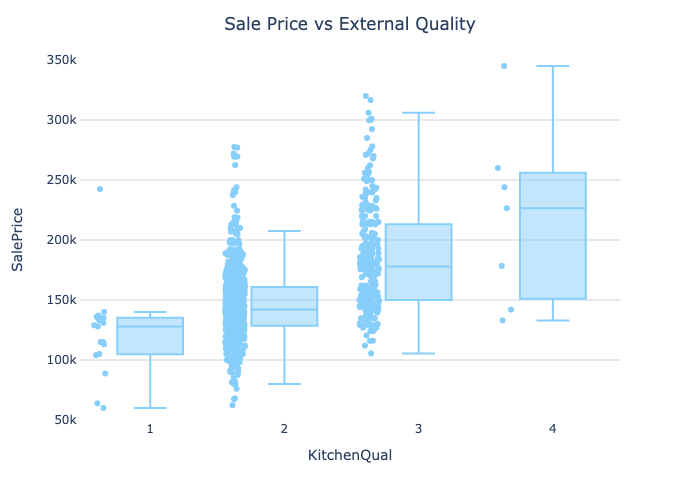

In [95]:
fig = px.box(
            data[data.Location_2==True], 
            x='KitchenQual', 
            y="SalePrice", 
            points="all")

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs External Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray', range=[50000,350000])

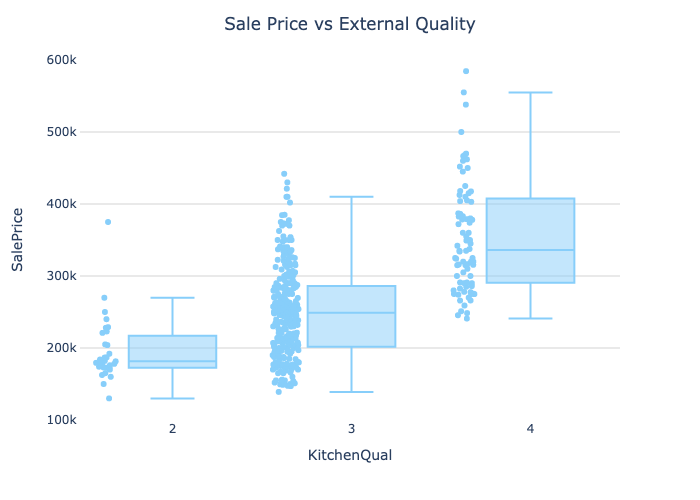

In [97]:
fig = px.box(
            data[data.Location_4==True], 
            x='KitchenQual', 
            y="SalePrice", 
            points="all")

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs External Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray', range=[100000,600000])

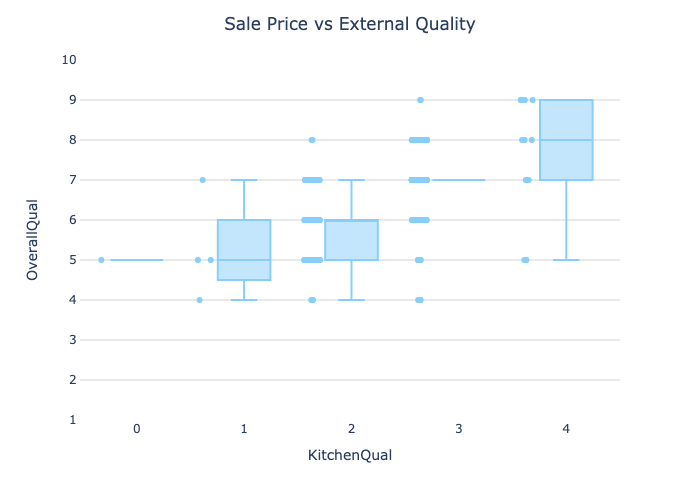

In [91]:
fig = px.box(
            data[data.Location_3==True], 
            x='KitchenQual', 
            y="OverallQual", 
            points="all")

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs External Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray', range=[1,10])

In [289]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

for location in (1,2,3,4):

    temp = data[data.Location==location]

    X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(temp, temp[['SalePrice']], test_size=0.30, random_state=42)


    scaler = StandardScaler()

    X_train_loc = X_train_loc.reset_index(drop=True)
    X_test_loc = X_test_loc.reset_index(drop=True)

    y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
    y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

    X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
    X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)
    X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

    model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                        GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                        HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                        Fireplaces + LotArea + MSSubClass + Remod +\
                        BsmtUnfSF + Zone + Location +\
                        RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + \
                        GrLivArea:Fireplaces', 
                        data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

    results_fu = model.fit()

    n = X_train.shape[0]
    results_fr = model.fit_regularized(L1_wt=0, alpha=0.1/n, start_params=results_fu.params)

    test_params = np.round(results_fr.params, 6)
    test_params[0] = results_fu.params[0]

    final = sm.regression.linear_model.OLSResults(model, 
                                                test_params,
                                                model.normalized_cov_params)

    final.summary()
    yhat_train_loc = final.predict(X_train_scaled_loc)
    yhat_test_loc = final.predict(X_test_scaled_loc)

    train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
    test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

    print(train_rmse_non_log)
    print(test_rmse_non_log)


    df_train_loc = pd.DataFrame(np.concatenate((np.array(yhat_train_loc).reshape(-1,1), np.array(y_train_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_train = pd.concat([df_train, df_train_loc], axis=0)

    df_test_loc = pd.DataFrame(np.concatenate((np.array(yhat_test_loc).reshape(-1,1), np.array(y_test_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_test = pd.concat([df_test, df_test_loc], axis=0)

14967.145056916183
17954.885752830392
12486.32407172351
13971.630134158188
14594.6442188339
15978.808895289756
21363.920440138478
22264.824542966584


In [290]:
train_rmse_non_log = mean_squared_error(np.exp(df_train.y_train), np.exp(df_train.yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(df_test.y_train), np.exp(df_test.yhat_train), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

15284.120119244455
16969.543531856038


In [316]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

for largerhouse in (0,1):

    temp = data[data.LargerHouse==largerhouse]

    X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(temp, temp[['SalePrice']], test_size=0.30, random_state=42)


    scaler = StandardScaler()

    X_train_loc = X_train_loc.reset_index(drop=True)
    X_test_loc = X_test_loc.reset_index(drop=True)

    y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
    y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

    X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
    X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)
    X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

    model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                        GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                        HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                        Fireplaces + LotArea + MSSubClass + Remod +\
                        BsmtUnfSF + Zone + Location +\
                        RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + \
                        GrLivArea:Fireplaces', 
                        data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

    results_fu = model.fit()

    n = X_train.shape[0]
    results_fr = model.fit_regularized(L1_wt=0, alpha=0.1/n, start_params=results_fu.params)

    test_params = np.round(results_fr.params, 6)
    test_params[0] = results_fu.params[0]

    final = sm.regression.linear_model.OLSResults(model, 
                                                test_params,
                                                model.normalized_cov_params)

    final.summary()
    yhat_train_loc = final.predict(X_train_scaled_loc)
    yhat_test_loc = final.predict(X_test_scaled_loc)

    train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
    test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

    print(train_rmse_non_log)
    print(test_rmse_non_log)


    df_train_loc = pd.DataFrame(np.concatenate((np.array(yhat_train_loc).reshape(-1,1), np.array(y_train_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_train = pd.concat([df_train, df_train_loc], axis=0)

    df_test_loc = pd.DataFrame(np.concatenate((np.array(yhat_test_loc).reshape(-1,1), np.array(y_test_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_test = pd.concat([df_test, df_test_loc], axis=0)

12029.213454270859
12841.20180309485
21348.483968640638
20760.613908068197


In [317]:
train_rmse_non_log = mean_squared_error(np.exp(df_train.y_train), np.exp(df_train.yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(df_test.y_train), np.exp(df_test.yhat_train), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16926.673464303858
16915.16525589369
